In [219]:
# pip installs
# !pip install pyspellchecker
# !pip install seaborn==0.11.2
# !pip install -U textblob
# !pip install nltk
# nltk.download('punkt')
# !pip install multimodal-transformers --user
## always restart kernel after installation
# !pip install tensorboard

In [2]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoConfig, Trainer, EvalPrediction, set_seed
from textblob import TextBlob
from transformers.training_args import TrainingArguments
from multimodal_transformers.data import load_data_from_folder
from multimodal_transformers.model import TabularConfig
from multimodal_transformers.model import AutoModelWithTabular
from dataclasses import dataclass, field
from typing import Optional
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

C:\Users\tan_k\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [27]:
nltk.download('punkt')
sent = "asfdnsdf"
blob = TextBlob(sent)
for sent in blob.sentences:
    print(sent.sentiment.polarity)
    print(sent.sentiment.subjectivity)

0.0
0.0


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tan_k\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
import seaborn as sns
sns.__version__

'0.11.2'

# Load Data

In [59]:
df = pd.read_csv(r'.')
df.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


In [60]:
df.describe(include=np.object)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
count,36765,36765,36765,36765,36765
unique,36765,4191,36691,7,3
top,9c0d045a6de1,900A879708F0,Summer projects should be student-designed,Evidence,Adequate
freq,1,23,14,12105,20977


In [61]:
df.describe()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
count,36765,36765,36765,36765,36765
unique,36765,4191,36691,7,3
top,9c0d045a6de1,900A879708F0,Summer projects should be student-designed,Evidence,Adequate
freq,1,23,14,12105,20977


In [62]:
df = df.drop(['discourse_id', 'essay_id'], axis=1)
for i in range(len(df)):
    df['discourse_text'][i] = ' '.join(df['discourse_text'][i].split()[:508])
df.head()

,discourse_text,discourse_type,discourse_effectiveness
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,"On my perspective, I think that the face is a ...",Position,Adequate
2,I think that the face is a natural landform be...,Claim,Adequate
3,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,People thought that the face was formed by ali...,Counterclaim,Adequate


# "Source<T/F>" feature

In [63]:
df['source'] = df['discourse_text'].apply(lambda x:'source' in x.lower().split())
df['source'].value_counts()

False    36376
True       389
Name: source, dtype: int64

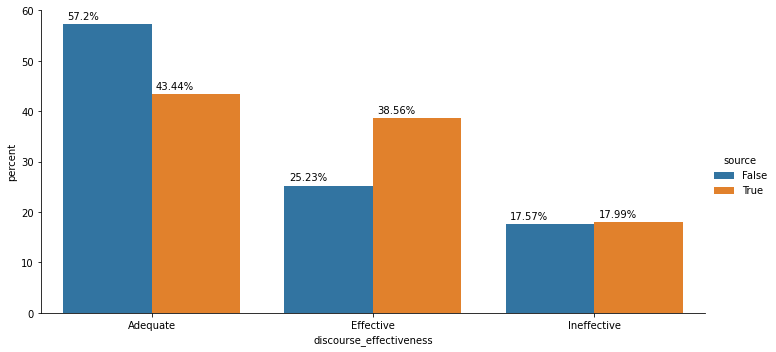

In [64]:
fig = (df[df['source'].notnull()]
.groupby('source')['discourse_effectiveness']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x='discourse_effectiveness',y='percent',hue='source',kind='bar', height=5,aspect =2))

for p in fig.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    fig.ax.text(txt_x + 0.02, txt_y + 1, txt)

In [65]:
df["source"] = df["source"].astype('category')
df["source"] = df["source"].cat.codes

In [66]:
df.head()

,discourse_text,discourse_type,discourse_effectiveness,source
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,0
1,"On my perspective, I think that the face is a ...",Position,Adequate,0
2,I think that the face is a natural landform be...,Claim,Adequate,0
3,"If life was on Mars, we would know by now. The...",Evidence,Adequate,0
4,People thought that the face was formed by ali...,Counterclaim,Adequate,0


# "Spelling<T/F>" Feature

In [67]:
from collections import Counter
from spellchecker import SpellChecker
from tqdm import tqdm
import string

In [68]:
%%time
counter = Counter()
for text in tqdm(df['discourse_text']):
    words = text.translate(str.maketrans('', '', string.punctuation)).split()
    misspelled = spell.unknown(words)
    counter.update(misspelled)

100%|█████████████████████████████████████████████████████████████████████████| 36765/36765 [00:03<00:00, 12243.73it/s]

Wall time: 3.05 s


In [69]:
counter.most_common(30)

[('studentdesigned', 357),
 ('b', 296),
 ('teacherdesigned', 281),
 ('c', 227),
 ('facs', 212),
 ('canidate', 203),
 ('winnertakeall', 196),
 ('genericname', 152),
 ('plumer', 150),
 ('canidates', 141),
 ('venuss', 129),
 ('f', 99),
 ('nasas', 88),
 ('electorial', 87),
 ('bestlaid', 84),
 ('heshe', 81),
 ('presidental', 76),
 ('vauban', 73),
 ('carfree', 73),
 ('garvin', 69),
 ('transregional', 68),
 ('driveless', 68),
 ('s', 66),
 ('ascertainment', 66),
 ('eckman', 63),
 ('elctoral', 62),
 ('mr', 60),
 ('recieves', 59),
 ('tv', 58),
 ('winnertakesall', 58)]

In [70]:
%%time
df['spelling'] = None
for i in range(len(df)):
    words = df['discourse_text'][i].translate(str.maketrans('', '', string.punctuation)).split()
    misspelled = spell.unknown(words)
#     print(misspelled)
#     print(len(misspelled))
    df['spelling'][i] = len(misspelled)

<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Wall time: 9.29 s


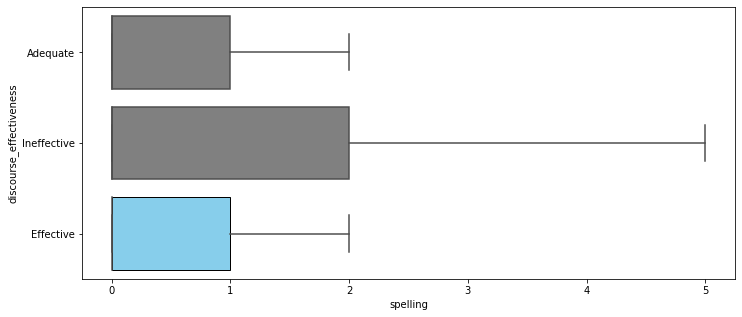

In [71]:
a4_dims = (11.7, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(x="spelling", y="discourse_effectiveness", data=df, showfliers = False, orient="h", ax=ax, color ='grey')
mybox = ax.artists[2]
mybox.set_facecolor('skyblue')
mybox.set_edgecolor('black')
mybox.set_linewidth(1)

## Number of words

In [73]:
%%time
df['count'] = None
for i in range(len(df)):
    word = df['discourse_text'][i]
    df['count'][i] = len(word.split())

<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Wall time: 5.34 s


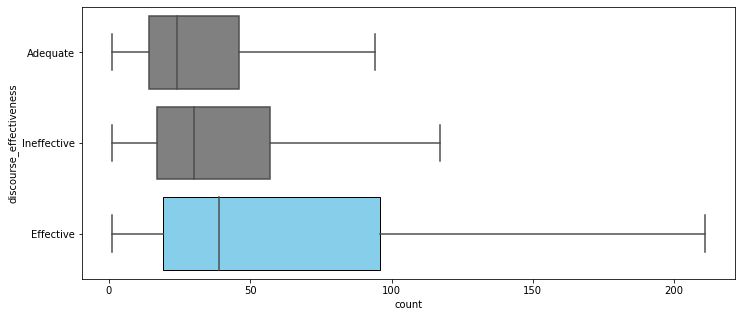

In [74]:
a4_dims = (11.7, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(x="count", y="discourse_effectiveness", data=df, showfliers = False, orient="h", ax=ax, color = 'grey')
mybox = ax.artists[2]
mybox.set_facecolor('skyblue')
mybox.set_edgecolor('black')
mybox.set_linewidth(1)

## Subjectivity and polarity

In [75]:
%%time
df['polarity'] = None
df['subjectivity'] = None
for i in range(len(df)):
    sent = df['discourse_text'][i]
    blob = TextBlob(sent)
    for sentence in blob.sentences:
        df['polarity'][i] = sentence.sentiment.polarity
        df['subjectivity'][i] = sentence.sentiment.subjectivity

<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Wall time: 43.8 s


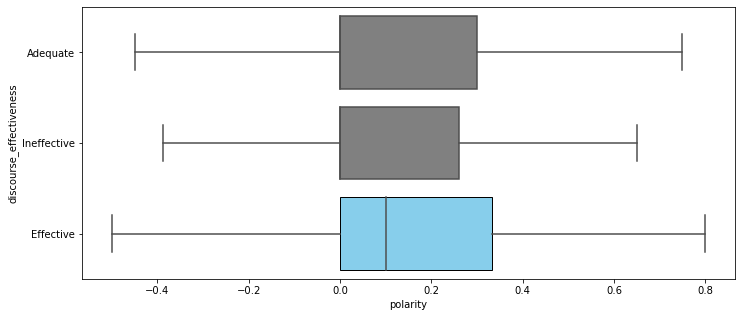

In [76]:
a4_dims = (11.7, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(x="polarity", y="discourse_effectiveness", data=df, showfliers = False, orient="h", ax=ax, color = 'grey')
mybox = ax.artists[2]
mybox.set_facecolor('skyblue')
mybox.set_edgecolor('black')
mybox.set_linewidth(1)

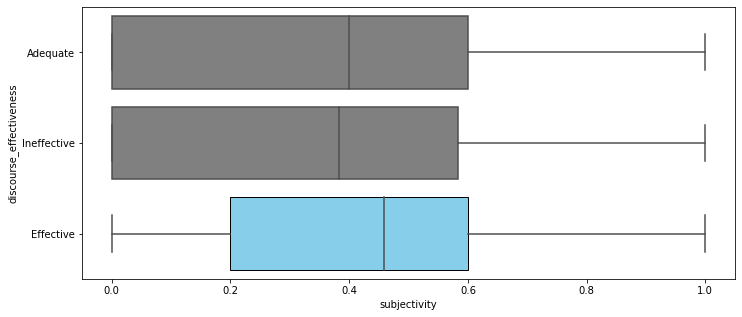

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

a4_dims = (11.7, 5)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(x="subjectivity", y="discourse_effectiveness", data=df, showfliers = False, orient="h", ax=ax, color = 'grey')
mybox = ax.artists[2]
mybox.set_facecolor('skyblue')
mybox.set_edgecolor('black')
mybox.set_linewidth(1)

plt.show()

## Discourse effectiveness

In [78]:
c = df["discourse_effectiveness"].astype('category')

d = dict(enumerate(c.cat.categories))
print (d)

{0: 'Adequate', 1: 'Effective', 2: 'Ineffective'}


In [90]:
df['discourse_effectiveness'].unique()

array(['Adequate', 'Ineffective', 'Effective'], dtype=object)

In [79]:
df.head()

,discourse_text,discourse_type,discourse_effectiveness,source,spelling,count,polarity,subjectivity
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,0,0,67,0.1,0.4
1,"On my perspective, I think that the face is a ...",Position,Adequate,0,0,41,-0.0333333,0.166667
2,I think that the face is a natural landform be...,Claim,Adequate,0,1,21,0.1,0.4
3,"If life was on Mars, we would know by now. The...",Evidence,Adequate,0,0,72,0.1,0.4
4,People thought that the face was formed by ali...,Counterclaim,Adequate,0,1,18,0,0


## Anova

In [105]:
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
df.info()
df["polarity"] = pd.to_numeric(df['polarity'])
df["spelling"] = pd.to_numeric(df['spelling'])
df['count'] = pd.to_numeric(df['count'])
df["spelling"].dropna(inplace=True)
df["polarity"].dropna(inplace=True)
df["subjectivity"].dropna(inplace=True)
df.info()
# mymod = ols('polarity ~ subjectivity', data = df[df.discourse_effectiveness == 'Ineffective']).fit() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36765 entries, 0 to 36764
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   discourse_text           36765 non-null  object 
 1   discourse_type           36765 non-null  object 
 2   discourse_effectiveness  36765 non-null  object 
 3   source                   36765 non-null  int8   
 4   spelling                 36765 non-null  object 
 5   count                    36765 non-null  object 
 6   polarity                 36765 non-null  float64
 7   subjectivity             36765 non-null  object 
dtypes: float64(1), int8(1), object(6)
memory usage: 2.0+ MB


In [110]:
import statsmodels.api as sm
for i in df['discourse_effectiveness'].unique():
    print(i)
    mymod = ols('spelling ~ count', data = df[df.discourse_effectiveness == i]).fit()
    aovtable = sm.stats.anova_lm(mymod, typ = 2)
    print(aovtable)
    print("\n")

Adequate
                sum_sq       df            F  PR(>F)
count      7028.571059      1.0  5830.027617     0.0
Residual  25287.063398  20975.0          NaN     NaN


Ineffective
                sum_sq      df            F  PR(>F)
count     22359.541538     1.0  6687.917215     0.0
Residual  21597.551777  6460.0          NaN     NaN


Effective
                sum_sq      df            F  PR(>F)
count      2149.938480     1.0  1948.171799     0.0
Residual  10289.660491  9324.0          NaN     NaN




In [103]:
mymod = ols('polarity ~ subjectivity', data = df[df.discourse_effectiveness == "Ineffective"]).fit()
aovtable = sm.stats.anova_lm(mymod, typ = 2)
print(aovtable)

                  sum_sq      df         F         PR(>F)
subjectivity  165.430791   848.0  3.616444  3.678423e-180
Residual      302.784604  5613.0       NaN            NaN
